In [9]:
import tensorflow as tf

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

#tf.enable_eager_execution()
tf.executing_eagerly()
tf.debugging.set_log_device_placement(False) 

# Emotion Dataset

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import preprocessing
from preprocessing import clean_html, non_ascii, lower, email_address, punct, remove_underscore

In [68]:
# header=None => leave the first line empty
# sep=';' => separate the emotions to be in an independent column
train_data = pd.read_csv('emotion_dataset/train.txt', header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
test_data = pd.read_csv('emotion_dataset/test.txt', header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
val_data = pd.read_csv('emotion_dataset/val.txt', header=None, sep=';', names=['Input', 'Sentiment'], encoding='utf-8')
df = pd.concat([train_data, test_data, val_data], axis=0) #by deafult, concat is by column
df = df.reset_index()

In [69]:
train_data

,Input,Sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [70]:
df.head()

,index,Input,Sentiment
0,0,i didnt feel humiliated,sadness
1,1,i can go from feeling so hopeless to so damned...,sadness
2,2,im grabbing a minute to post i feel greedy wrong,anger
3,3,i am ever feeling nostalgic about the fireplac...,love
4,4,i am feeling grouchy,anger


In [71]:
# PREPROCESS THE DATA
def preproc(df, colname):
  df[colname] = df[colname].apply(func=clean_html) 
  df[colname] = df[colname].apply(func=non_ascii)
  df[colname] = df[colname].apply(func=lower)
  df[colname] = df[colname].apply(func=email_address)
  # sentiment anaysis might not need stopword removal ex: not like, not is a stopword
  # df[colname] = df[colname].apply(func=removeStopWords) 
  df[colname] = df[colname].apply(func=punct)
  df[colname] = df[colname].apply(func=remove_underscore)
  return(df)

df_clean = preproc(df, 'Input')
#df_clean.drop('index', axis=1, inplace=True)
df_clean['num_words'] = df_clean['Input'].apply(lambda x: len(x.split()))
df_clean['Sentiment'] = df_clean['Sentiment'].astype('category').cat.codes
encoded_dict = {'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5} 

In [72]:
df_clean

,index,Input,Sentiment,num_words
0,0,didnt feel humiliated,4,3
1,1,can go from feeling so hopeless to so damned ...,4,20
2,2,m grabbing a minute to post i feel greedy wrong,0,10
3,3,am ever feeling nostalgic about the fireplace...,3,17
4,4,am feeling grouchy,0,3
...,...,...,...,...
19995,1995,m having ssa examination tomorrow in the morni...,4,34
19996,1996,constantly worry about their fight against na...,2,28
19997,1997,feel its important to share this info for tho...,2,14
19998,1998,truly feel that if you are passionate enough ...,2,18


In [75]:
df_clean['num_words'].describe() # might determine the max_len

count    20000.000000
mean        18.240150
std         10.956682
min          1.000000
25%         10.000000
50%         16.000000
75%         24.000000
max         65.000000
Name: num_words, dtype: float64

In [57]:

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel 

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42,
                                     stratify=df_clean['Sentiment'])

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

max_len = 70

X_train = tokenizer(
    text=df_train['Input'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=df_test['Input'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False, 
    return_attention_mask=True,
    verbose=True
)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [80]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
#from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
#from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [81]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

embeddings = bert(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

y = Dense(6, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

optimizer = Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08, # a very small number to prevent any division by zero
    decay=0.01, # learning rate schedule, learning_rate = learningrate * 1/(1+decay*epoch)
    clipnorm=1.0 # to prevent gradient exploding and gradient vanishing. Clipping is a method where the error derivative is changed or clipped ot a threshold
)

#loss = CategoricalCrossentropy(from_logits=True)
loss = CategoricalCrossentropy()
metric = CategoricalAccuracy('balanced_accuracy')
#metric = SparseCategoricalAccuracy()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(df_train['Sentiment']),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        to_categorical(df_test['Sentiment'])),
    epochs=1,
    batch_size=32
) 
""" 
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

loss = SparseCategoricalCrossentropy()
metric = SparseCategoricalAccuracy('balanced_accuracy')
#metric = SparseCategoricalAccuracy()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    #y = to_categorical(df_train['Sentiment']),
    y = df_train['Sentiment'],
    #validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
    #                    to_categorical(df_test['Sentiment'])),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        df_test['Sentiment']),
    epochs=1,
    batch_size=32
)  """

2022-11-16 12:31:48.676319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - ETA: 0s - loss: 0.6212 - balanced_accuracy: 0.7804

2022-11-16 13:36:55.754970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 4174s 9s/step - loss: 0.6212 - balanced_accuracy: 0.7804 - val_loss: 0.2390 - val_balanced_accuracy: 0.9180


In [102]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                          

In [132]:
model.save_weights("./bert_emotion_weights/model_weight")

In [96]:
model.load_weights("./bert_emotion_weights/model_weight")

In [97]:
history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(df_train['Sentiment']),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        to_categorical(df_test['Sentiment'])),
    epochs=2,
    batch_size=32
) 

Epoch 1/2
438/438 [==============================] - 4154s 9s/step - loss: 0.2030 - balanced_accuracy: 0.9237 - val_loss: 0.1874 - val_balanced_accuracy: 0.9258
Epoch 2/2
438/438 [==============================] - 5664s 13s/step - loss: 0.1524 - balanced_accuracy: 0.9367 - val_loss: 0.1765 - val_balanced_accuracy: 0.9277


In [98]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

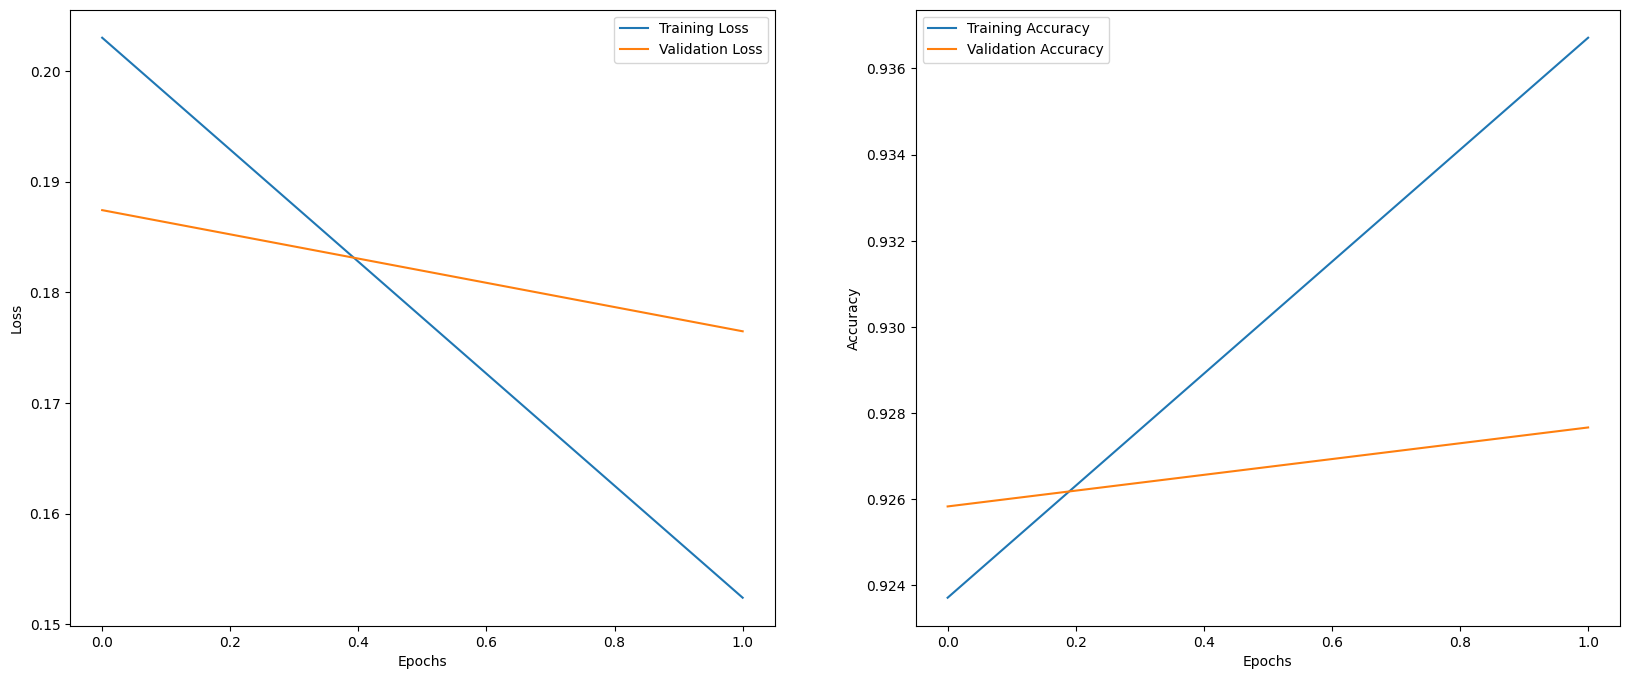

In [99]:
# plot function
def plot_curve(hist):
    epochs = hist.epoch
    f, ax = plt.subplots(ncols=2, figsize=(20,8))
    ax[0].plot(epochs, hist.history['loss'], label='Training Loss')
    ax[0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(epochs, hist.history['balanced_accuracy'], label='Training Accuracy')
    ax[1].plot(epochs, hist.history['val_balanced_accuracy'], label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
plot_curve(history)

188/188 [==============================] - 257s 1s/step


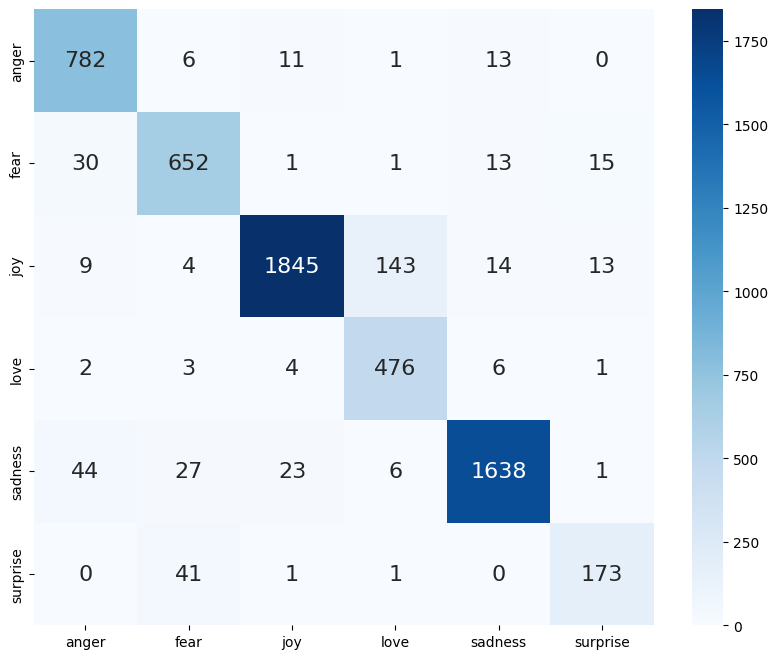

In [100]:
class_names = encoded_dict.keys()
predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
# confustion_matrix(y_true, y_prediction)
cnf_matrix = confusion_matrix(df_test['Sentiment'], y_predicted)
df_cnf = pd.DataFrame(cnf_matrix, class_names, class_names)
plt.figure(figsize=(10, 8))
sn.heatmap(df_cnf, annot=True, cmap='Blues', annot_kws={"size": 16},fmt='g')
plt.show()

In [101]:
from sklearn.metrics import classification_report
print(classification_report(df_test['Sentiment'], y_predicted, target_names=class_names))

              precision    recall  f1-score   support

       anger       0.90      0.96      0.93       813
        fear       0.89      0.92      0.90       712
         joy       0.98      0.91      0.94      2028
        love       0.76      0.97      0.85       492
     sadness       0.97      0.94      0.96      1739
    surprise       0.85      0.80      0.83       216

    accuracy                           0.93      6000
   macro avg       0.89      0.92      0.90      6000
weighted avg       0.93      0.93      0.93      6000



In [130]:
# test_single
text = "Life is too short to be serious all the time. So if you can’t laugh at yourself, call me I will laugh at you"
df_single = pd.DataFrame({"Input": [text]})
df_single_clean = preproc(df_single, 'Input')
#df_clean.drop('index', axis=1, inplace=True)
df_single_clean['num_words'] = df_clean['Input'].apply(lambda x: len(x.split()))
#df_single_clean['Sentiment'] = df_clean['Sentiment'].astype('category').cat.codes
df_single = tokenizer(
    text=df_single_clean['Input'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding="max_length", # since test single here, to make is padding to 70, cange from True to "max_legth"
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)
predicted_single = model.predict({'input_ids': df_single['input_ids'], 'attention_mask': df_single['attention_mask']})
y_predicted_single = np.argmax(predicted_single, axis=1)
y_predicted_single = list(encoded_dict.keys())[y_predicted_single[0]]
y_predicted_single

1/1 [==============================] - 9s 9s/step


'joy'

# IBMD Movie Review

In [1]:
import pandas as pd
from preprocessing import clean_html, non_ascii, lower, email_address, punct, remove_underscore, stemming, lemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jinghuang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('imdb_dataset/IMDB Dataset.csv')
df = df.head(20000) # original 50000 is too many to train
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
19995,"ok. for starters, taxi driver is amazing. this...",negative
19996,"It's sort of hard for me to say it, because I ...",negative
19997,I still liked it though. Warren Beatty is only...,positive
19998,We could still use Black Adder even today. Ima...,positive


In [9]:
# PREPROCESS THE DATA
def preproc(df, colname):
  df[colname] = df[colname].apply(func=clean_html) 
  df[colname] = df[colname].apply(func=non_ascii)
  df[colname] = df[colname].apply(func=lower)
  df[colname] = df[colname].apply(func=email_address)
  # sentiment anaysis might not need stopword removal ex: not like, not is a stopword
  # df[colname] = df[colname].apply(func=removeStopWords) 
  df[colname] = df[colname].apply(func=punct)
  df[colname] = df[colname].apply(func=remove_underscore)
  df[colname] = df[colname].apply(func=stemming)
  df[colname] = df[colname].apply(func=lemmatizer)
  return(df)

df_clean = preproc(df, 'review')
df_clean['num_words'] = df_clean['review'].apply(lambda x: len(x.split()))
df_clean['sentiment'] = df_clean['sentiment'].astype('category').cat.codes
#encoded_dict = {'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4, 'surprise':5} 
encoded_dict = {'negative': 0, 'positive':1}
#encoded_dict

In [10]:
df_clean.loc[0].review

'one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked  they are right  as this is exactly what happened with me the first thing that struck me about oz was its brutality and unflinching scenes of violence  which set in right from the word go  trust me  this is not a show for the faint hearted or timid  this show pulls no punches with regards to drugs  sex or violence  its is hardcore  in the classic use of the word it is called oz as that is the nickname given to the oswald maximum security state penitentary  it focuses mainly on emerald city  an experimental section of the prison where all the cells have glass fronts and face inwards  so privacy is not high on the agenda  em city is home to many  aryans  muslims  gangstas  latinos  christians  italians  irish and more    so scuffles  death stares  dodgy dealings and shady agreements are never far away i would say the main appeal of the show is due to the fact that it goes where other shows wo

In [5]:
df_clean

,review,sentiment,num_words
0,one of the other reviewers has mentioned that ...,1,314
1,a wonderful little production the filming tec...,1,160
2,i thought this was a wonderful way to spend ti...,1,168
3,basically there s a family where a little boy ...,0,135
4,petter mattei s love in the time of money is...,1,228
...,...,...,...
19995,ok for starters taxi driver is amazing this...,0,136
19996,it s sort of hard for me to say it because i ...,0,524
19997,i still liked it though warren beatty is only...,1,363
19998,we could still use black adder even today ima...,1,179


In [7]:
df_clean['num_words'].describe()

count    40000.000000
mean       225.891275
std        166.836885
min          4.000000
25%        124.000000
50%        170.000000
75%        274.000000
max       2450.000000
Name: num_words, dtype: float64

In [6]:

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFBertModel 

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42,
                                     stratify=df_clean['sentiment'])

tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

# max_len is very important and depdendent on the length of input.
# the average count of words is 225, here we set max_len to be 300. 
# very hard to run if max_len too big
#max_len = 70
max_len = 300

X_train = tokenizer(
    text=df_train['review'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=df_test['review'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False, 
    return_attention_mask=True,
    verbose=True
)

2022-11-18 21:08:37.728147: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-18 21:08:37.728582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
#from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
#from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [10]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
# embeddings = dbert_model(input_ids, attention_mask = input_mask)[0]

embeddings = bert(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)

y = Dense(6, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True # the second layer in the model is bert 
#for param in model.bert.parameters():
#    param.requires_grad = False
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 300)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 300,                                           

In [11]:
optimizer = Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08, # a very small number to prevent any division by zero
    decay=0.01, # learning rate schedule, learning_rate = learningrate * 1/(1+decay*epoch)
    clipnorm=1.0 # to prevent gradient exploding and gradient vanishing. Clipping is a method where the error derivative is changed or clipped ot a threshold
)

loss = SparseCategoricalCrossentropy()
metric = SparseCategoricalAccuracy('balanced_accuracy')
#metric = SparseCategoricalAccuracy()

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metric
)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = df_train['sentiment'],
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        df_test['sentiment']),
    epochs=3,
    batch_size=32
)

Epoch 1/3


2022-11-18 21:09:04.179801: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2022-11-18 21:09:13.752871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - ETA: 0s - loss: 0.3577 - balanced_accuracy: 0.8419 

2022-11-19 02:35:03.339065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


438/438 [==============================] - 20396s 47s/step - loss: 0.3577 - balanced_accuracy: 0.8419 - val_loss: 0.2262 - val_balanced_accuracy: 0.9137
Epoch 2/3
438/438 [==============================] - 20433s 47s/step - loss: 0.2003 - balanced_accuracy: 0.9219 - val_loss: 0.2112 - val_balanced_accuracy: 0.9155
Epoch 3/3
438/438 [==============================] - 21127s 48s/step - loss: 0.1489 - balanced_accuracy: 0.9479 - val_loss: 0.2146 - val_balanced_accuracy: 0.9152


In [12]:
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [13]:
loss, accuracy = model.evaluate({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        df_test['sentiment'])

188/188 [==============================] - 705s 4s/step - loss: 0.2146 - balanced_accuracy: 0.9152


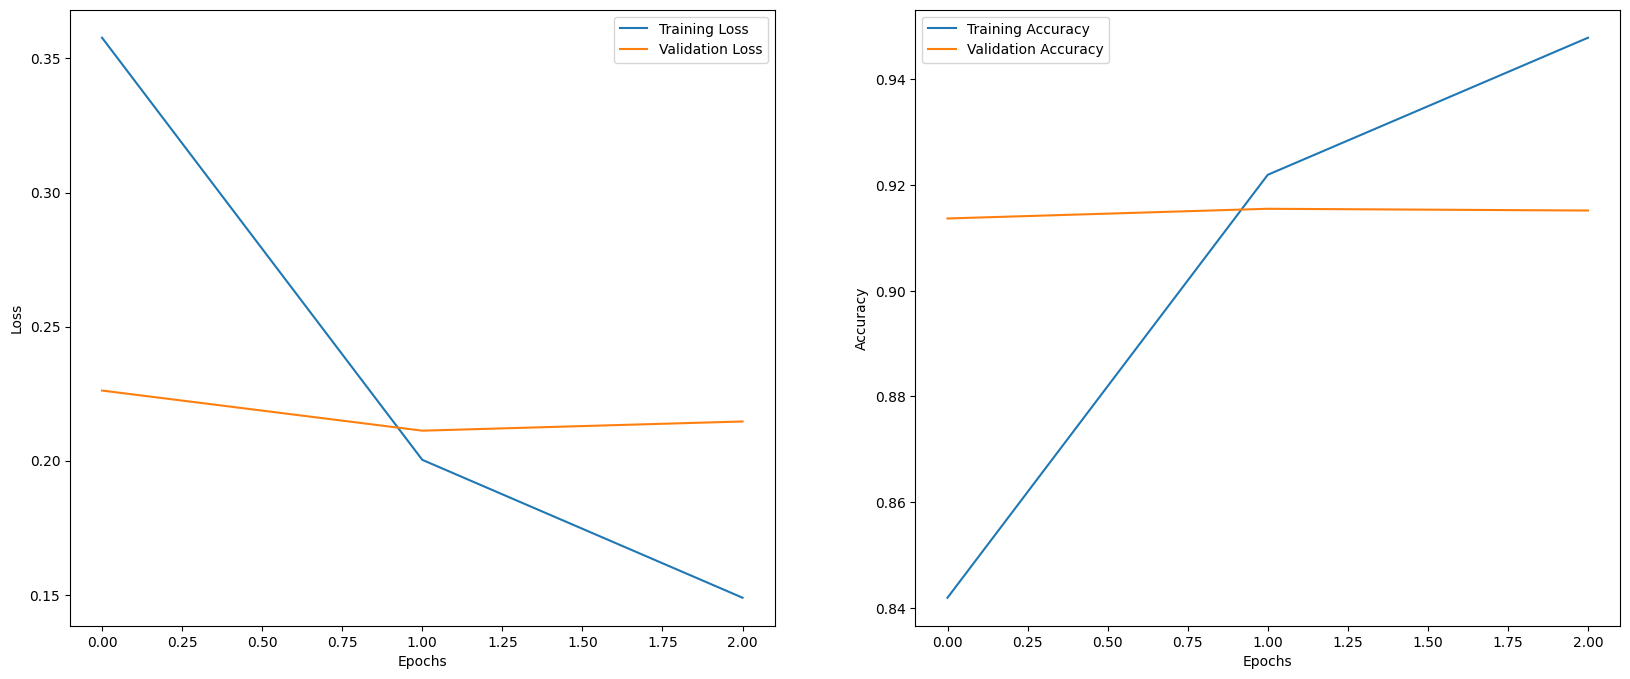

In [14]:
# plot function
def plot_curve(hist):
    epochs = hist.epoch
    f, ax = plt.subplots(ncols=2, figsize=(20,8))
    ax[0].plot(epochs, hist.history['loss'], label='Training Loss')
    ax[0].plot(epochs, hist.history['val_loss'], label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(epochs, hist.history['balanced_accuracy'], label='Training Accuracy')
    ax[1].plot(epochs, hist.history['val_balanced_accuracy'], label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
plot_curve(history)

2022-11-19 14:35:56.856265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 719s 4s/step


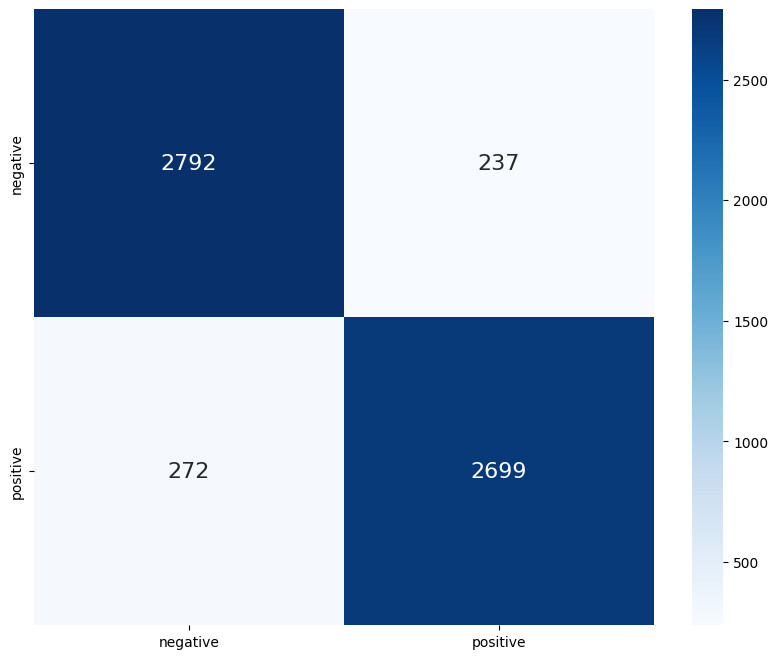

In [15]:
class_names = encoded_dict.keys()
predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
y_predicted = np.argmax(predicted, axis=1)
# confustion_matrix(y_true, y_prediction)
cnf_matrix = confusion_matrix(df_test['sentiment'], y_predicted)
df_cnf = pd.DataFrame(cnf_matrix, class_names, class_names)
plt.figure(figsize=(10, 8))
sn.heatmap(df_cnf, annot=True, cmap='Blues', annot_kws={"size": 16},fmt='g')
plt.show()

In [16]:
df_test['sentiment'].value_counts() 

0    3029
1    2971
Name: sentiment, dtype: int64

In [17]:
from sklearn.metrics import classification_report
print(classification_report(df_test['sentiment'], y_predicted, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.91      0.92      0.92      3029
    positive       0.92      0.91      0.91      2971

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



In [19]:
# test_single
# positive
text = "This movie deserves the 10 I'm giving it.<br /><br />But it's not the 10 that you'd give to movies like 'The Godfather' or 'Goodfellas' or 'Psycho'. This is the kind of 10 you give to a movie which just makes you laugh,over and over again! It's the most horribly written and directed movie, yet it doesn't fail to entertain. It has the most amateur effects, yet you enjoy every moment! I saw this movie today on TV, and I didn't want to move away! Read the following dialogue to know why!<br /><br />(Whole college is standing around Manisha,who has just undergone a rape attempt and the guys who attempted the rape are asking for forgiveness)<br /><br />Bad Guy 1: Please forgive us! <br /><br />Bad guy 2: Yes,we won't do it again. <br /><br />(No response from Manisha) <br /><br />Akshay: Come on,forgive them! <br /><br />Manisha: I don't know... <br /><br />Akshay: You are a beautiful woman, and even dead men can get aroused by you! And these are living young males! Don't blame them!<br /><br />Pancholi: Yeah Manisha.. <br /><br />Manisha(To Suniel): What if they tried to rape your girlfriend??? <br /><br />Suniel: I'd break their hands,legs and kill them.But anyways,just forgive them..<br /><br />Akshay: Yeah if you don't forgive them then it will be as though you are too arrogant about your beauty!<br /><br />Now that is a true masterpiece of a dialogue! This movie never fails to entertain, mainly because there are so many goofs and unrealistic situations! The bad guy (Munish) can do basically anything..He can blow a sandstorm from his mouth, or he can get a motorcycle from his backside and just as easily make it disappear again. <br /><br />Every actor takes turns to speak..One line from Akshay,then from Suniel, then from Arshad, then Aftab, then Nigam. It's the main rule followed by the director, so that equal screen time is given to each guy. And then there's the all powerful pendant, which can cause even a speeding car to go right through you without you being harmed! All these things make it an enjoyable movie, and I can watch it over and over again. I think this movie can go into the comedy hall of fame if there is one..<br /><br />The only problem is that it wasn't trying to be funny."
df_single = pd.DataFrame({"review": [text]})
df_single_clean = preproc(df_single, 'review')
#df_clean.drop('index', axis=1, inplace=True)
df_single_clean['num_words'] = df_clean['review'].apply(lambda x: len(x.split()))
#df_single_clean['Sentiment'] = df_clean['Sentiment'].astype('category').cat.codes
df_single = tokenizer(
    text=df_single_clean['review'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding="max_length", # since test single here, to make is padding to 70, cange from True to "max_legth"
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)
predicted_single = model.predict({'input_ids': df_single['input_ids'], 'attention_mask': df_single['attention_mask']})
y_predicted_single = np.argmax(predicted_single, axis=1)
y_predicted_single = list(encoded_dict.keys())[y_predicted_single[0]]
y_predicted_single

1/1 [==============================] - 2s 2s/step


'negative'

In [21]:
df_single_clean

,review,num_words
0,this movie deserves the 10 im giving itbut its...,301
